### One Owner Model

As a benchmark to the revenues generated from the producers inside the water regulation procedure, we will have a look at how a theoretical river system behaves, where every power plant is operated by one decision maker. The revenues are then distributed according to how much production capacity the individual producers have: If producer A has a total of 1 and producer B has a total of 2 for all equivalents, then B gets 2/3 of the revenue and A gets 1/3.  
We will see how much revenue will be generated and compare this to the revenue generated in the water regulation system.  

We can leave out the water regulation rules in these optimization models. We develop 

* Stochastic Bidding Model
* Stochastic Short-Term Optimization Model

We obviously don't have to do any balancing other than necessary in this problem, as we can freely adjust how much water we use without any constraint on average discharge. 


In [45]:
using JuMP
using CPLEX
using Distributions
using Combinatorics
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

In [17]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
println("Reservoirs: ", [r.dischargepoint for r in R])
println("Power Plants - Spill Reference")
for k in K
    println("$(k.name) -  $(k.spillreference)")
end

Reservoirs: ["Flasjon", "Holsmjon"]
Power Plants - Spill Reference
Flasjo -  58.0
Trangfors -  105.0
Ratan -  115.0
Turinge -  105.0
Bursnas -  105.0
Jarnvagsforsen -  145.0
Parteboda -  140.0
Hermansboda -  140.0
Ljunga -  145.0
Nederede -  240.0
Skallbole -  265.0
Matfors -  250.0
Viforsen -  160.0


#### Data

In [31]:
function prepare_pricedata(filepath_prices::String)::DataFrame
    price_data = CSV.read(filepath_prices, DataFrame)
    price_data = coalesce.(price_data, 46.79)
    price_data.Average = sum.(eachrow(price_data[:, 2:end]))/24
    rename!(price_data, :Column1 => :Date)
    price_data.season = get_season.(month.(price_data.Date))
    price_data.Weekday = dayofweek.(price_data.Date)
    price_data.Weekday = get_weekend.(price_data.Weekday)
    price_data.CalendarWeek = Dates.week.(price_data.Date)
    return price_data
end

function prepare_inflowdata(filepath_inflow::String)::DataFrame
    inflow_data = CSV.read(filepath_inflow, DataFrame)
    inflow_data.CalendarWeek = Dates.week.(inflow_data.Date)
    coalesce.(inflow_data, 0.0)
    inflow_data[!, "Flasjon Inflow"] = coalesce.(inflow_data[!, "Flasjon Inflow"], 0)
    return inflow_data
end
function get_season(month::Int64)::String
    if month in 3:4  
        return "Spring"
    elseif month in 5:8  
        return "Summer"
    elseif month in 9:11  
        return "Autumn"
    else  
        return "Winter"
    end
end

function get_weekend(weekday::Int64)::String
    if weekday in 1:5
        return "Weekday"
    else
        return "Weekend"
    end
end

"""
Inflow_Scenarios(inflow_data, ColumnReservoir, n, R)

Create n weekly Scenarios based on the inflow data for an entire year (roughly 52 weeks). For Correspondence between reservoir and column name another dictionary ColumnReservoir is necessary.
To prevent negative inflow values, the negative part of the inflow scenarios is cut off. (Negative inflow values occur in the data, but are related to measuring errors and weather effects)
"""
function Inflow_Scenarios_Weekly(inflow_data::DataFrame, ColumnReservoir::Dict{Reservoir, String}, n::Int64, R::Vector{Reservoir})
    gd_inflow = groupby(df_inflow[! ,["Holmsjon Inflow", "Flasjon Inflow", "CalendarWeek"]], :CalendarWeek)
    WeeklyInflowDistribution = Dict{Reservoir, Any}()
    WeeklyInflowDistribution[R[2]] = Normal{Float64}[fit_mle(Normal{Float64}, g[!,ColumnReservoir[R[2]]]) for g in gd_inflow]
    WeeklyInflowDistribution[R[1]] = Normal{Float64}[fit_mle(Normal{Float64}, g[!,ColumnReservoir[R[1]]]) for g in gd_inflow]
    InflowScenarios = Dict(i => Dict(R[1] => max.(rand(WeeklyInflowDistribution[R[1]][i], n), 0),
                                     R[2] => max.(rand(WeeklyInflowDistribution[R[2]][i], n), 0)) for i in eachindex(WeeklyInflowDistribution[R[1]]))

    return InflowScenarios
end

function Price_Scenarios_Weekly(price_data::DataFrame, n::Int64)
    gd = groupby(df_prices[!,[:Average, :CalendarWeek]], :CalendarWeek)
    WeeklyPriceDistribution = Rayleigh{Float64}[fit_mle(Rayleigh{Float64}, g[!,:Average]) for g in gd]
    PriceScenarios = Dict(i => max.(rand(WeeklyPriceDistribution[i], n), 0) for i in eachindex(WeeklyPriceDistribution))
    return PriceScenarios
end

df_prices = prepare_pricedata("Inflow Forecasting\\Data\\Spot Prices\\prices_df.csv")
df_inflow = prepare_inflowdata("Inflow Forecasting\\Data\\Inflow\\Data from Flasjoen and Holmsjoen.csv")

ColumnReservoir = Dict{Reservoir, String}(R[1] => "Flasjon Inflow", R[2] => "Holmsjon Inflow")
InflowScenarios = Inflow_Scenarios_Weekly(df_inflow, ColumnReservoir, 3, R)
PriceScenarios = Price_Scenarios_Weekly(df_prices, 3)

"""

create_Ω(PriceScenarios, InflowScenarios, R)

    Create Uncertainty Sets for each stage by forming the cartesian product of prices and inflows at each reservoir. 
"""
function create_Ω_medium(PriceScenarios::Dict{Int64, Vector{Float64}}, InflowScenarios::Dict{Int64, Dict{Reservoir, Vector{Float64}}}, R::Vector{Reservoir})
    Ω = Dict(i => [(inflow = Dict(R[1] =>  InflowScenarios[i][R[1]][j], R[2] => InflowScenarios[i][R[2]][j]), price = P) for P in PriceScenarios[i] for j in eachindex(InflowScenarios[i][R[1]])] for i in 1:52)
    P = Dict(i => [1/length(Ω[i]) for j in eachindex(Ω[i])] for i in 1:52)
    return Ω, P 
end

Ω, P = create_Ω_medium(PriceScenarios, InflowScenarios, R)

(Dict{Int64, Vector{NamedTuple{(:inflow, :price), Tuple{Dict{Reservoir, Float64}, Float64}}}}(5 => [(inflow = ________________________________
Flasjon  | 6.667606913407977
Holsmjon | 3.22193019080804
, price = 75.69208556626462), (inflow = ________________________________
Flasjon  | 4.7487184073294335
Holsmjon | 14.028513360519023
, price = 75.69208556626462), (inflow = ________________________________
Flasjon  | 9.988777169608221
Holsmjon | 2.4244299112800367
, price = 75.69208556626462), (inflow = ________________________________
Flasjon  | 6.667606913407977
Holsmjon | 3.22193019080804
, price = 69.67641932648527), (inflow = ________________________________
Flasjon  | 4.7487184073294335
Holsmjon | 14.028513360519023
, price = 69.67641932648527), (inflow = ________________________________
Flasjon  | 9.988777169608221
Holsmjon | 2.4244299112800367
, price = 69.67641932648527), (inflow = ________________________________
Flasjon  | 6.667606913407977
Holsmjon | 3.22193019080804
, price = 

### Medium Term Model & Water Values

Before we can solve the bidding and short term Optimization models, we have to solve a seasonal model to input marginal water values.

In [32]:
model_medium, V_medium = MediumTermModel(
    R::Vector{Reservoir},
    K::Vector{HydropowerPlant},
    Ω::Dict{Int64, Vector{NamedTuple{(:inflow, :price), Tuple{Dict{Reservoir, Float64}, Float64}}}},
    P::Dict{Int64, Vector{Float64}},
    52;
    iterations = 500,
    stopping_rule = [SDDP.BoundStalling(10, 1e1)],
    printlevel = 1,
    loop = true
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 52
  state variables : 2
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [24, 24]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  AffExpr in MOI.LessThan{Float64}        : [13, 13]
  VariableRef in MOI.GreaterThan{Float64} : [6, 6]
  VariableRef in MOI.LessThan{Float64}    : [16, 16]
numerical stability report
  matrix range     [7e-02, 1e+00]
  objective range  [1e+00, 4e+02]
  bounds range     [7e+00, 2e+07]
  rhs range        [0e+00, 0e+00]
  - bounds range contains large coefficients
Very large or small absolute values of coefficients
can cause numerical stability issues

         1   1.234462e+06  1.685632e+07  2.170000e-01       529   1


         5   1.689599e+06  1.222770e+07  1.237000e+00     14085   1


        11   2.148722e+07  1.102807e+07  2.571000e+00     31299   1


        18   1.174600e+07  1.030795e+07  3.769000e+00     46962   1


        26   4.230849e+07  1.011057e+07  5.414000e+00     67314   1


        31   6.046465e+06  1.002971e+07  6.533000e+00     80359   1


        34   4.426766e+06  9.969312e+06  7.584000e+00     92346   1


        41   2.411680e+06  9.949565e+06  8.607000e+00    103849   1


        44   1.544774e+07  9.934615e+06  9.869000e+00    117396   1


        65   3.258747e+07  9.900693e+06  1.514400e+01    172185   1


        84   1.291489e+07  9.889817e+06  2.042900e+01    223316   1


       101   1.726560e+07  9.879669e+06  2.554100e+01    269749   1


       120   1.387332e+07  9.874197e+06  3.085300e+01    316200   1


       137   1.773855e+07  9.867863e+06  3.613100e+01    360553   1


       148   2.130850e+07  9.866235e+06  4.140500e+01    402252   1


       164   1.918651e+07  9.862063e+06  4.704100e+01    445556   1


       176   1.547842e+06  9.860128e+06  5.207700e+01    482584   1


       187   1.891142e+06  9.858699e+06  5.709000e+01    517523   1


       205   9.601116e+06  9.856479e+06  6.244800e+01    553565   1


       222   7.741922e+06  9.855069e+06  6.754400e+01    585438   1


       231   7.916399e+06  9.854306e+06  7.266000e+01    617239   1


       246   2.311920e+06  9.852783e+06  7.771600e+01    649094   1


       257   2.262454e+07  9.851691e+06  8.276900e+01    678313   1


       268   2.557269e+07  9.850684e+06  8.853800e+01    712212   1


       280   2.976807e+07  9.849648e+06  9.364700e+01    742480   1


       289   1.832560e+07  9.849335e+06  9.906000e+01    773241   1


       297   5.172151e+07  9.849018e+06  1.065210e+02    812833   1


       309   3.090919e+07  9.848215e+06  1.119790e+02    842061   1


       323   1.869316e+07  9.846796e+06  1.172850e+02    870267   1


       376   1.253307e+07  9.843853e+06  1.479480e+02   1025704   1


       421   1.576310e+07  9.841204e+06  1.788860e+02   1162349   1


       467   1.189191e+07  9.839425e+06  2.089160e+02   1281323   1


       500   6.648684e+06  9.838638e+06  2.302140e+02   1361700   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 2.302140e+02
total solves   : 1361700
best bound     :  9.838638e+06
simulation ci  :  1.012677e+07 ± 7.312320e+05
numeric issues : 0
-------------------------------------------------------------------



(A policy graph with 52 nodes.
 Node indices: 1, ..., 52
, A value function for node 1)

In [73]:
reservoircutvalues = Dict(r => [r.currentvolume, 0.0, r.currentvolume/2] for r in R)
combs = Iterators.product(values(reservoircutvalues)...)
cuts = Dict(i => Dict(r => v for (r,v) in zip(keys(reservoircutvalues), combo)) for (i, combo) in enumerate(combs))
print(values(cuts))
WaterCuts = WaterValueCuts(R, V_medium, cuts)
for (k, v) in WaterCuts
    println("For the Reservoir Levels \n", k[R[1]])
    println("We reveive the cut coefficients: \n ", v.e2[R[1]])
end

Dict{Reservoir, Float64}[________________________________
Flasjon  | 0.0     
Holsmjon | 0.0     
, ________________________________
Flasjon  | 2000.0  
Holsmjon | 0.0     
, ________________________________
Flasjon  | 1000.0  
Holsmjon | 0.0     
, ________________________________
Flasjon  | 2000.0  
Holsmjon | 400.0   
, ________________________________
Flasjon  | 0.0     
Holsmjon | 800.0   
, ________________________________
Flasjon  | 1000.0  
Holsmjon | 400.0   
, ________________________________
Flasjon  | 0.0     
Holsmjon | 400.0   
, ________________________________
Flasjon  | 1000.0  
Holsmjon | 800.0   
, ________________________________
Flasjon  | 2000.0  
Holsmjon | 800.0   
]Dict{Dict{Reservoir, Float64}, NamedTuple{(:e1, :e2), Tuple{Float64, Dict{Symbol, Float64}}}}(________________________________
Flasjon  | 1000.0  
Holsmjon | 400.0   
 => (e1 = 215476.26799239218, e2 = Dict(Symbol("l[Holsmjon]") => 233.31582839274193, Symbol("l[Flasjon]") => 462.1428696558911)), ____

KeyError: KeyError: key Flasjon not found

### Bidding Model

We approximate the bidding problem by using linear interpolation of volumes and presetting price Points, for example based on probabilities. From that we obtain the delivery obligation.

$$
y_t = \frac{c_t - P_{t,i} }{P_{t,i+1} - P_{t,i}} \cdot x_{i,t} + \frac{P_{t,i+1} - c_t }{P_{t,i+1} - P{t,i}} \cdot x_{i+1,t}, \qquad \text{if} \qquad P_{t,i} \leq c_t \leq P_{t,i+1}
$$

### Water Value

We approximate the Water Value Function using linear cuts from the medium term model:


$$
\alpha^c \leq \varphi_M^c(l) - \sum\limits_{r \in \mathbb{R}} \pi_r^c \cdot (l_{r}^c - l_{r,t+1})
$$

NamedTuple{(:inflow, :price), Tuple{Dict{Reservoir, Float64}, Vector{Float64}}}[(inflow = ________________________________
Flasjon  | 0.4     
Holsmjon | 0.4     
, price = [0.8330119979327184, 0.6775414873972102, 0.7440759401325545, 0.4688031797868234, 0.6823091187182123, 0.4822012277334068, 0.00361123769986893, 0.7697545200459357, 0.36662562695418055, 0.9662107034830214, 0.5676885636536875, 0.06594768590055744, 0.6565512870368382, 0.4322230858845001, 0.13999121914601909, 0.41389819995372856, 0.036165786229696906, 0.7633216589733137, 0.3363645953298988, 0.3721719495695257, 0.007929400668686748, 0.23302706640201598, 0.058810179502233106, 0.9136803977648946]), (inflow = ________________________________
Flasjon  | 0.6     
Holsmjon | 0.6     
, price = [0.8574499937190749, 0.23691892256327496, 0.4479706167326165, 0.24854342449943956, 0.8071962471224062, 0.7268814733044033, 0.19598659252208883, 0.49449513160501457, 0.7957828906292216, 0.01000222801870998, 0.038767426397696925, 0.827220850

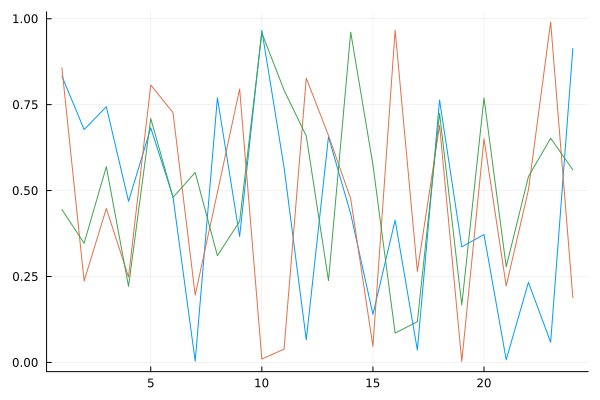

In [76]:
I = 5
T = 24
Stages = 2

mu_up = 1.0
mu_down = 0.1
S = 0.3

PPoints = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
@assert length(PPoints) == I + 1
Omega = [(inflow = Dict(r => 0.4 for r in R), price = rand(T)), (inflow = Dict(r => 0.6 for r in R), price = rand(T)), (inflow = Dict(r => 0.8 for r in R), price = rand(T))]
P = [1/length(Omega) for om in Omega]
println(Omega)
Plots.plot(x = 1:T, [om.price for om in Omega], legend = false, show=true)

"""
    create_Ω(price_data, inflow_scenarios, weekday, season, scenario_count, J; quantile_bounds, stage_count)
"""
function create_Ω(price_data, inflow_scenarios, weekday::String, season::String, SCENARIO_COUNT::Int64, parts::Array{Participant}; quantile_bounds = 0.1, STAGE_COUNT = STAGE_COUNT)
    price_quantiles = quantile(price_data.Sum, range(quantile_bounds, 1 - quantile_bounds, length = SCENARIO_COUNT+1))
    price_subsets = Dict{Int64, DataFrame}()
    for i in 1:SCENARIO_COUNT
        price_subsets[i] = price_data[(price_data.Sum .>= price_quantiles[i]) .& (price_data.Sum .<= price_quantiles[i+1]), :]
    end
    price_scenarios = Dict{Int64, Vector{Any}}()
    for s in 1:SCENARIO_COUNT
        price_scenarios[s] = [collect(values(row)) for row in eachrow(select(price_subsets[s], Not([:Date, :Weekday, :season, :Sum])))]
    end
    price_sample = Dict(s =>  [price_scenarios[scen][rand(1:length(price_scenarios[scen]))] for scen in 1:SCENARIO_COUNT] for s in 1:STAGE_COUNT)
    Ω = Dict(s => [(price = c, inflow = Q) for c in price_sample[s] for Q in inflow_scenarios] for s in 1:STAGE_COUNT)
    P = Dict(s => [1/length(eachindex(Ω[s])) for i in eachindex(Ω[s])] for s in 1:STAGE_COUNT)
    Ω_scenario = Dict(scenario => Dict(s => [(price = Ω[s][scenario].price, inflow = Ω[s][scenario].inflow)] for s in 1:STAGE_COUNT) for scenario in 1:SCENARIO_COUNT)
    P_scenario = Dict(scenario => Dict(s => [1/length(eachindex(Ω_scenario[scenario][s])) for i in eachindex(Ω_scenario[scenario][s])] for s in 1:STAGE_COUNT) for scenario in 1:SCENARIO_COUNT)
    price_threshold::Dict{Participant, Dict{Reservoir, Float64}} = Dict(p => Dict(r => quantile(price_data.Sum,0.45) for r in res) for p in parts) 
    max_hourly_price = max([max([mean(s) for s in sample]...) for sample in values(price_sample)]...)
    return Ω, P
end 

In [95]:
function subproblem_builder_single_bidding(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    @variable(subproblem, 0 <= x[i = 1:I+1, t = 1:T] <= sum(k.equivalent * k.spillreference for k in K), SDDP.State, initial_value = 0)
    # Transition Function
    @constraint(subproblem, increasing[i = 1:I, t=1:T], x[i,t].out <= x[i+1,t].out)
    if node == 1
        # We only concern ourselves with bidding in the first stage.
        @stageobjective(subproblem, 0)
        @constraint(subproblem, balance_transfer[r = R], l[r].out == l[r].in) # No Inflow In first stage (or fixed value)
        @constraint(subproblem, start_transfer[k = K], ustart[k].out == ustart[k].in)
    else
        # Some Constraints and variables such as production specific components only become relevant in stage >= 2
        @variable(subproblem, y[t = 1:T] >= 0)
        @variable(subproblem, a) # Water Value through cuts
        @variable(subproblem, 0 <= Qreal[t = 1:T, r = R])
        @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.equivalent * k.spillreference)
        @variable(subproblem, u[t = 1:T, k = K], Bin)
        @variable(subproblem, d[t = 1:T, k = K], Bin)
        @variable(subproblem, s[r = R] >= 0)
        @variable(subproblem, z_up[t = 1:T] >= 0)
        @variable(subproblem, z_down[t = 1:T] >= 0)
        # Random Variables
        @variable(subproblem, f[r = R])
        @constraint(subproblem, watervalue[c = values(cuts)], a <= WaterCuts[c].e1 - sum(WaterCuts[c].e2[Symbol("l[$(r)]")] *(c[r] - l[r].out) for r in R))
        @constraint(subproblem, clearing[t=1:T], y[t] == sum(1* x[i,t].in +  1* x[i+1,t].in for i in 1:I-1))
        @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Qreal[t,r] for t in 1:T)/T + f[r] - s[r])
        @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
        @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])
        # Constraints
        @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
        @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
        @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Qreal[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
        @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t, k] for k in K) + z_up[t] - z_down[t])
        # Parameterize Uncertainty and Objective Function
        SDDP.parameterize(subproblem, Omega, P) do om
            for r in R
                JuMP.fix(f[r], om.inflow[r], force=true)
            end
            # Define Set of active variables for each hour
            I_t = Dict(t => 0 for t in 1:T)
            for t in 1:T
                for i in 1:I
                    if (om.price[t] >= PPoints[i]) && (om.price[t] <= PPoints[i+1])
                        I_t[t] = i
                    end
                end
            end
            # Parameterize objective through uncertain price
            @stageobjective(subproblem, sum(om.price[t] * y[t] -  mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) + a for t in 1:T))
            # Fix / Deactivate constraints by setting their coefficients to appropriate values or all zero.
            for t in 1:T
                for i in 1:I
                    if (i == I_t[t])
                        set_normalized_coefficient(clearing[t], x[i,t].in, -((om.price[t] - PPoints[i])/(PPoints[i+1] - PPoints[i])))
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, -((PPoints[i+1] - om.price[t])/(PPoints[i+1] - PPoints[i])))
                    else
                        set_normalized_coefficient(clearing[t], x[i,t].in, 0)
                        set_normalized_coefficient(clearing[t], x[i+1,t].in, 0)
                    end
                end
            end
        end
    end
end

subproblem_builder_single_bidding (generic function with 1 method)

In [96]:
model_single_bidding = SDDP.LinearPolicyGraph(
    subproblem_builder_single_bidding;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * sum(sum(k.spillreference * k.equivalent for k in K) for t in 1:T for s in 1:Stages),
    optimizer = CPLEX.Optimizer
)

A policy graph with 2 nodes.
 Node indices: 1, 2


In [97]:
SDDP.train(
    model_single_bidding;
    iteration_limit = 10,
    print_level = 1
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 2
  state variables : 159
  scenarios       : 3.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [319, 1380]
  AffExpr in MOI.EqualTo{Float64}         : [15, 76]
  AffExpr in MOI.GreaterThan{Float64}     : [299, 299]
  AffExpr in MOI.LessThan{Float64}        : [120, 753]
  VariableRef in MOI.GreaterThan{Float64} : [146, 581]
  VariableRef in MOI.LessThan{Float64}    : [147, 459]
  VariableRef in MOI.ZeroOne              : [13, 637]


numerical stability report
  matrix range     [1e-02, 6e+02]
  objective range  [3e-03, 2e+01]
  bounds range     [7e+00, 7e+04]
  rhs range        [6e+04, 1e+06]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   1.335983e+04  1.577573e+04  6.599998e-02         6   1


        10   1.373685e+04  1.373685e+04  5.929999e-01        66   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 5.929999e-01
total solves   : 66
best bound     :  1.373685e+04
simulation ci  :  1.343273e+04 ± 2.584706e+03
numeric issues : 0
-------------------------------------------------------------------



In [98]:
rule_single_bidding = SDDP.DecisionRule(model_single_bidding; node = 1)
sol_single_bidding = SDDP.evaluate(
    rule_single_bidding;
    incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
    controls_to_record = [:x],
)

println([sol_single_bidding[3][:x][i].out for i in eachindex(sol_single_bidding[3][:x])])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.1800000000001, 684.1800000000001, 0.0, 0.0, 0.0, 0.0, 684.18000000000

### Short-Term Optimization

The problem is parameterized by a known demand $y$ in the first stage.
Bidding is removed from the optimization model. Determining a discharge schedule is the most important thing about the model. For the current production day we know

* Inflow
* Price
* Obligation

In the future the parameters

* Inflow
* Price

are considered unknown.

24


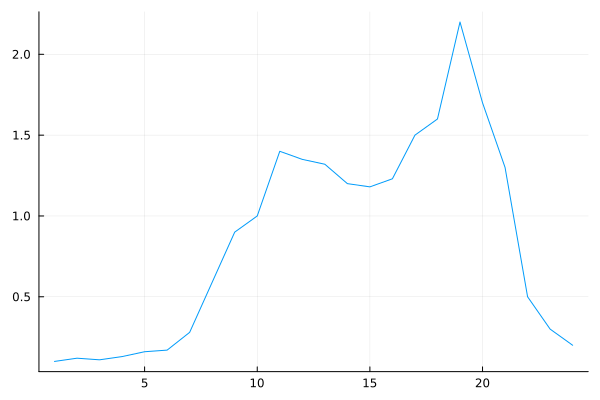

In [99]:
y_initial::Vector{Float64} = [0.1, 0.12, 0.11, 0.13, 0.16, 0.17, 0.28, 0.59, 0.9, 1.0, 1.4, 1.35, 1.32, 1.2, 1.18, 1.23, 1.5, 1.6, 2.2, 1.7, 1.3, 0.5, 0.3, 0.2]
println(length(y_initial))
price = rand(T)
f_initial = Dict{Reservoir, Float64}(r => 0.4 for r in R)
Plots.plot(1:24, y_initial, legend = false, show = true)

In [104]:
function subproblem_builder_single_short(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, SDDP.State, initial_value = r.currentvolume)
    @variable(subproblem, ustart[k = K], Bin, SDDP.State, initial_value = 0)
    # Control Variables
    @variable(subproblem, y[t = 1:T])
    @variable(subproblem, Q[t = 1:T, r = R] >= 0)
    @variable(subproblem, 0 <= w[t = 1:T, k = K] <= k.spillreference * k.equivalent)
    @variable(subproblem, 0 <= u[t = 1:T, k = K], Bin)
    @variable(subproblem, 0 <= d[t = 1:T, k = K], Bin)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, a)
    # Random Variables
    @variable(subproblem, f[r = R])

    # Transition function
    @constraint(subproblem, balance[r = R], l[r].out == l[r].in - sum(Q[t, r] for t in 1:T) + T * f[r] - s[r])
    @constraint(subproblem, planttrans1[k = K], ustart[k].in == u[1,k])
    @constraint(subproblem, planttrans2[k = K], ustart[k].out == u[T,k])
    # Constraints
    if node == 1
        @variable(subproblem, z_up[t = 1:T] >= 0)
        @variable(subproblem, z_down[t = 1:T] >= 0)
        @constraint(subproblem, obligation[t = 1:T], y[t] == sum(w[t,k] for k in K) + z_up[t] - z_down[t])
    end
    @constraint(subproblem, startup[t = 1:T-1, k = K], d[t,k] >= u[t+1,k] - u[t,k])
    @constraint(subproblem, activeplant[t = 1:T, k = K], w[t,k] <= u[t,k] * k.equivalent * k.spillreference)
    @constraint(subproblem, production[t = 1:T, k = K], w[t,k] <= sum(Q[t, r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    @constraint(subproblem, watervalue[c = values(cuts)], a <= WaterCuts[c].e1 - sum(WaterCuts[c].e2[Symbol("l[$(r)]")] *(c[r] - l[r].out) for r in R))
    # Parameterize Uncertainty
    SDDP.parameterize(subproblem, Omega, P) do om
        if node == 1
            for t in 1:T
                JuMP.fix(y[t], y_initial[t])
            end
            for r in R
                JuMP.fix(f[r], f_initial[r])
            end
            @stageobjective(subproblem, sum(price[t] * y[t] - mu_up * z_up[t] + mu_down * z_down[t]  - sum(S * d[t,k] for k in K) for t in 1:T) + a)
        else
            for r in R
                JuMP.fix(f[r], om.inflow[r])
            end
            @stageobjective(subproblem, sum(om.price[t] * sum(w[t, k] for k in K) - sum(S * d[t, k] for k in K) for t in 1:T) + a)
        end
    end
end

subproblem_builder_single_short (generic function with 1 method)

In [105]:
model_single_short = SDDP.LinearPolicyGraph(
    subproblem_builder_single_short;
    stages = Stages,
    sense = :Max,
    upper_bound = Stages * T * sum(k.spillreference * k.equivalent for k in K),
    optimizer = CPLEX.Optimizer
)

A policy graph with 2 nodes.
 Node indices: 1, 2


In [106]:
SDDP.train(
    model_single_short;
    iteration_limit = 10
)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 2
  state variables : 15
  scenarios       : 9.00000e+00
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [1044, 1092]
  AffExpr in MOI.EqualTo{Float64}         : [28, 52]
  AffExpr in MOI.GreaterThan{Float64}     : [299, 299]
  AffExpr in MOI.LessThan{Float64}        : [633, 633]
  VariableRef in MOI.GreaterThan{Float64} : [989, 1036]
  VariableRef in MOI.LessThan{Float64}    : [315, 315]
  VariableRef in MOI.ZeroOne              : [637, 637]
numerical stability report
  matrix range     [7e-02, 6e+02]
  objective range  [3e-03, 1e+00]
  bounds range     [7e+00, 3e+04]
  rhs range        [6e+04, 1e+06]


         1   3.661930e+04  3.252733e+04  1.430001e-01         8   1


         6   3.661930e+04  3.204036e+04  1.186000e+00        66   1


        10   3.661930e+04  3.204036e+04  1.873000e+00        98   1
-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 1.873000e+00
total solves   : 98
best bound     :  3.204036e+04
simulation ci  :  3.570312e+04 ± 1.197142e+03
numeric issues : 0
-------------------------------------------------------------------



In [107]:
rule_single_short = SDDP.DecisionRule(model_single_short; node = 1)
sol_single_short = SDDP.evaluate(
    rule_single_short;
    incoming_state = Dict(Symbol("l[$(r.dischargepoint)]") => r.currentvolume for r in R),
    controls_to_record = [:Q, :u, :d],
)

println(sol_single_short[3])

Dict{Symbol, JuMP.Containers.DenseAxisArray{Float64, 2, Ax, L} where {Ax, L<:Tuple{JuMP.Containers._AxisLookup, JuMP.Containers._AxisLookup}}}(:d => 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(24)
    Dimension 2, HydropowerPlant[Flasjo, Trangfors, Ratan, Turinge, Bursnas, Jarnvagsforsen, Parteboda, Hermansboda, Ljunga, Nederede, Skallbole, Matfors, Viforsen]
And data, a 24×13 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.